In [5]:
!pip install matplotlib
!pip install ipywidgets

import requests
from datetime import datetime
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve RDI data from FRED API
api_key = os.environ.get('api_key')  # Fetch the API key from environment variables
series_id = "A229RX0"
today = datetime.today().strftime('%Y-%m-%d')
url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start=1960-01-01&observation_end={today}&frequency=a"

# Send a request to the FRED API and get the JSON response
response = requests.get(url)
data = response.json()["observations"]

In [6]:
# Define the presidents' names dictionary with start and end years
presidents = {
    (1960, 1964): 'Lyndon B. Johnson - 1st term',
    (1964, 1968): 'Lyndon B. Johnson - 2nd term',
    (1968, 1972): 'Richard Nixon',
    (1972, 1976): 'Gerald Ford',
    (1976, 1980): 'Jimmy Carter',
    (1980, 1984): 'Ronald Reagan - 1st term',
    (1984, 1988): 'Ronald Reagan - 2nd term',
    (1988, 1992): 'George H.W. Bush',
    (1992, 1996): 'Bill Clinton - 1st term',
    (1996, 2000): 'Bill Clinton - 2nd term',
    (2000, 2004): 'George W. Bush - 1st term',
    (2004, 2008): 'George W. Bush - 2nd term',
    (2008, 2012): 'Barack Obama - 1st term',
    (2012, 2016): 'Barack Obama - 2nd term',
    (2016, 2020): 'Donald Trump',
    (2020, 2024): 'Joe Biden'  # Assuming Biden's term is ongoing
}

# Define a function to get the president's name for a given year
def get_president_name(year):
    year = int(year)
    for (start_year, end_year), president_name in presidents.items():
        if start_year <= year < end_year:
            return president_name
    return None

# Extract RDI data and create DataFrame
rdi_dict = {}
data_sorted = sorted(data, key=lambda x: x['date'])  # Sort data by year
for year_data in data_sorted:
    year = year_data['date'][:4]  # Extract year from date
    rdi_value = year_data['value']  # Assuming 'value' field contains RDI data
    if rdi_value is None or not rdi_value.isnumeric():
        rdi_dict[year] = None
    else:
        rdi_dict[year] = float(rdi_value)

# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(rdi_dict, orient='index', columns=['usvalue'])
df.index.name = 'date'  # Rename the 'year' column to 'date'
# Add the 'presidents' column based on the assigned names using apply function
df['presidents'] = df.index.map(get_president_name)
df['growthvalue'] = np.log(df['usvalue'] / df['usvalue'].shift()) * 100

# Add the 'presidents' column based on the 'presidents' dictionary
#df['presidents'] = df.index.map(lambda x: presidents.get(int(x), None))

# Add the 'fecha' column with the UTC year and month encoding
df['utcyymm'] = [f"{year_data['date'][:4]}-{year_data['date'][5:7]}" for year_data in data_sorted]

# Rearrange the columns in the specified order
df = df[['utcyymm', 'usvalue', 'growthvalue', 'presidents']]

# Save the DataFrame as a CSV file
#file_path = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/df_data.csv"
#df.to_csv(file_path)
file_path2 = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/docs/assets/charts/data/df_data.csv"
df.to_csv(file_path2)

In [7]:
import pandas as pd

dropbox_url = "https://www.dropbox.com/scl/fi/s17h2uz3pxaqffbnrcxy7/df_vote.csv?rlkey=ostwpsa0m6syqzke0kpkwf892&dl=1"

# Download the CSV content using pandas
df_vote = pd.read_csv(dropbox_url, index_col=0)  # Assuming index is in the first column

# Convert the index 'year' to datetime objects
#df_vote.index = pd.to_datetime(df_vote.index, format='%Y')

# Modify the index to only include year and month (e.g., "1944-01")
#df_vote.index = df_vote.index.to_period('M')

file_path3 = "C:/Users/danbo/OneDrive - Fundacao Getulio Vargas - FGV/Info_Vote/R Code/docs/assets/charts/data/df_vote.csv"
df_vote.to_csv(file_path3, index=True)  # Save without index

print(df_vote.head())

       economy  RDI_y  RDI_1  RDI_2  RDI_3  RDI_4    demvote    repvote  \
year                                                                      
1944  5.704023    2.3   13.0   10.7    3.1    2.3  53.400002  45.900002   
1948  2.241379    3.5   -2.4   -1.9   -5.8    3.5  49.549999  45.070000   
1952  5.632184    1.5   -1.1    7.0    1.2    1.5  44.380001  55.130001   
1956  6.609196    3.0    3.1   -0.4    4.8    3.0  41.950001  57.380001   
1960  3.477012    0.6    0.6   -0.7    2.6    0.6  49.720001  49.549999   

      incterms  dem_inc   gnp3  gnp4    incvote  _merge  inc_margin  
year                                                                 
1944         3        1  13.69  6.48  53.400002       3    7.500000  
1948         4        1  -2.96  2.49  49.549999       3    4.479999  
1952         5        1   5.72  1.96  44.380001       3  -10.750000  
1956         1        0   5.14  0.21  57.380001       3   15.430000  
1960         2        0   5.45  0.82  49.549999       

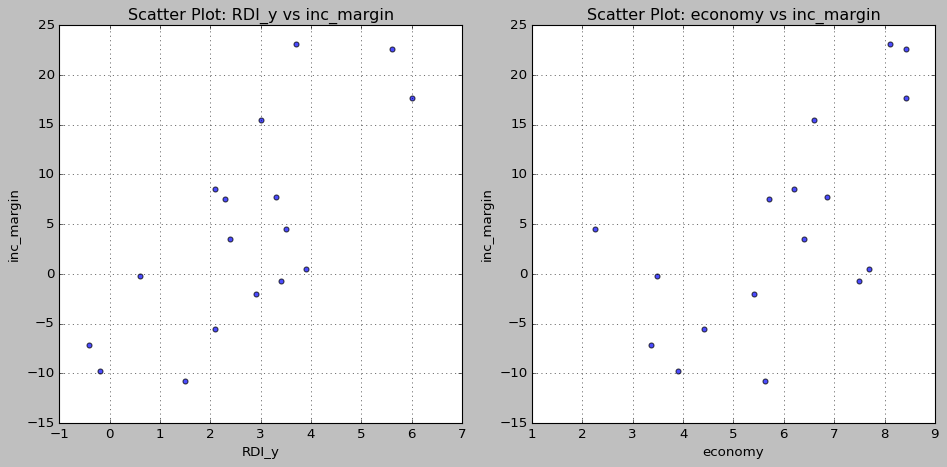

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('classic')  # Set the classic style

# Assuming you have already read the CSV and have the DataFrame df_vote

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of RDI_y against inc_margin
axs[0].scatter(df_vote['RDI_y'], df_vote['inc_margin'], alpha=0.7)
axs[0].set_title('Scatter Plot: RDI_y vs inc_margin')
axs[0].set_xlabel('RDI_y')
axs[0].set_ylabel('inc_margin')
axs[0].grid(True)

# Scatter plot of economy against inc_margin
axs[1].scatter(df_vote['economy'], df_vote['inc_margin'], alpha=0.7)
axs[1].set_title('Scatter Plot: economy vs inc_margin')
axs[1].set_xlabel('economy')
axs[1].set_ylabel('inc_margin')
axs[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_15376\2888708876.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-ticks')


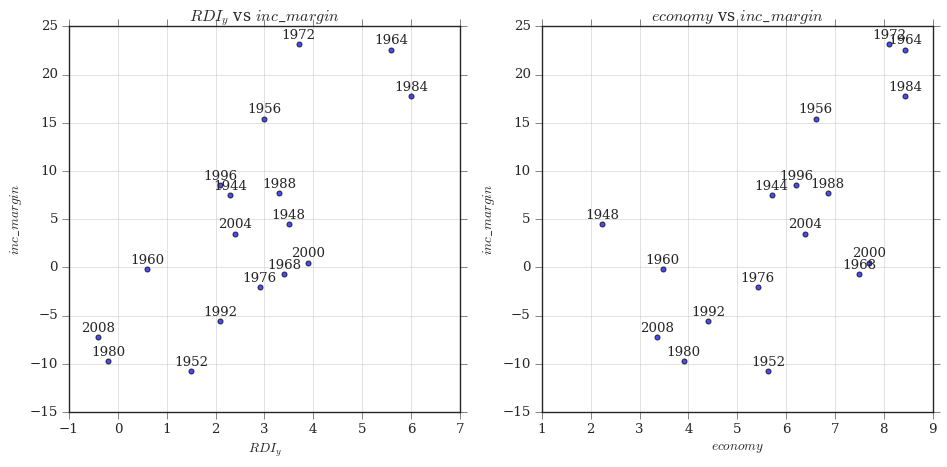

In [23]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

dropbox_url = "https://www.dropbox.com/scl/fi/s17h2uz3pxaqffbnrcxy7/df_vote.csv?rlkey=ostwpsa0m6syqzke0kpkwf892&dl=1"

# Download the CSV content using pandas
df_vote = pd.read_csv(dropbox_url, index_col=0)

# Set LaTeX-like theme
plt.style.use('seaborn-ticks')
plt.rcParams['font.family'] = 'serif'

# Assuming you have already read the CSV and have the DataFrame df_vote

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of RDI_y against inc_margin with year labels (on the left)
axs[0].scatter(df_vote['RDI_y'], df_vote['inc_margin'], alpha=0.7)
for i, row in df_vote.iterrows():
    year_str = str(i)  # Convert index year to string
    axs[0].annotate(year_str, (row['RDI_y'], row['inc_margin']), textcoords="offset points", xytext=(0,5), ha='center')
axs[0].set_title('$RDI_y$ vs $inc\_margin$')
axs[0].set_xlabel('$RDI_y$')
axs[0].set_ylabel('$inc\_margin$')
axs[0].grid(True)

# Scatter plot of economy against inc_margin with year labels (on the right)
axs[1].scatter(df_vote['economy'], df_vote['inc_margin'], alpha=0.7)
for i, row in df_vote.iterrows():
    year_str = str(i)  # Convert index year to string
    axs[1].annotate(year_str, (row['economy'], row['inc_margin']), textcoords="offset points", xytext=(0,5), ha='center')
axs[1].set_title('$economy$ vs $inc\_margin$')
axs[1].set_xlabel('$economy$')
axs[1].set_ylabel('$inc\_margin$')
axs[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
#plt.savefig(r"C:\Users\danbo\OneDrive - Fundacao Getulio Vargas - FGV\FGV\Q3.23\GIT\GIT\incmarg.png")

# Display the saved plot
plt.show()

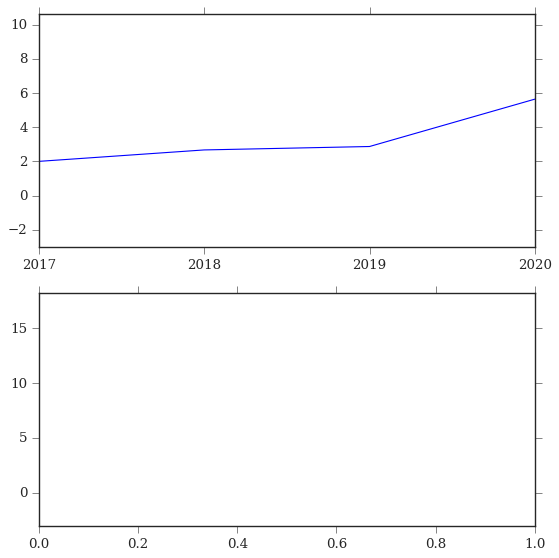

interactive(children=(IntSlider(value=2020, description='Election Year', max=2024, min=1964, step=4), Output()…

<function __main__.plot_growth(election_year)>

In [19]:
# Define a function to plot the RDI growth with a slider for election periods (For election year only)
def plot_growth(election_year):
    # Filter the data for the selected election period
    year_range = range(election_year - 3, election_year + 1)
    df_range = df.loc[df.index.isin(str(y) for y in year_range)]
    cumulative_range = df_range['growthvalue'].cumsum().sort_index()  # Change to 'growthvalue'

    # Define plot size and space
    fig, axs = plt.subplots(2, 1, figsize=(8, 8))
    axs[0].set_ylim(bottom=min(df_range['growthvalue']) - 5, top=max(df_range['growthvalue']) + 5)
    axs[1].set_ylim(bottom=min(cumulative_range) - 5, top=max(cumulative_range) + 5)

    # Plot the Yearly RDI growth for the selected period
    axs[0].plot(df_range.index, df_range['growthvalue'], label='Yearly')
    axs[0].set_title('Yearly Personal Income Growth for {}-{} ({})'.format(year_range[0], year_range[-1], presidents[election_year]), pad=20)
    axs[0].set_xlabel('Year')
    axs[0].set_ylabel('% Change in Personal Income')
    axs[0].legend()

    for x, y in zip(df_range.index, df_range['growthvalue']):
        axs[0].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')  # Adjusted xytext to move data labels inside the plot space

    # Plot the Cumulative RDI growth for the selected period
    axs[1].plot(cumulative_range.index, cumulative_range, label='Cumulative')
    axs[1].set_title('Yearly Personal Income Growth for {}-{} ({})'.format(year_range[0], year_range[-1], presidents[election_year]), pad=20, fontsize=12)
    subtitle_text = "Each year adds the growth of all previous years, so the 4th Year shows the total growth from Years 1st-4th"
    axs[1].text(0.5, 1.01, subtitle_text, fontsize=10, ha='center', va='bottom', transform=axs[1].transAxes)
    axs[1].set_xlabel('Year')
    axs[1].set_ylabel('% Change in Personal Income')
    axs[1].legend()

    for x, y in zip(cumulative_range.index, cumulative_range):
        axs[1].annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

    plt.tight_layout()
    plt.show()

# Create a slider for election years
election_slider = IntSlider(min=1964, max=2024, step=4, value=2020, description='Election Year')
interact(plot_growth, election_year=election_slider)